In [78]:
from cv2 import imwrite,imread
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

def show(image,image_name = "sus.jpg",gray = False,save = False):
    plt.figure(figsize=(12, 10))
    if gray :
        plt.imshow(image, cmap='gray')
    else :
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')
    if save :
        plt.savefig(image_name,bbox_inches = 'tight')
    plt.show()

def final_bb(possible_contours,image):
    # Find the minimum and maximum x and y coordinates of the boxes
    if len(possible_contours) == 0  :
        return image
    min_x = min([d['x'] for d in possible_contours])
    max_x = max([d['x'] + d['w'] for d in possible_contours])
    min_y = min([d['y'] for d in possible_contours])
    max_y = max([d['y'] + d['h'] for d in possible_contours])

    copy = image.copy()
    cv2.rectangle(copy, pt1=(min_x, min_y), pt2=(max_x, max_y), color=(255, 255, 255), thickness=2)
    return copy

def maximize_contrast(gray):

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return gray

def drawbox(image_path):
    """
    creates bouding box around the image and returns it
    """
    img_ori = imread(image_path)

    height, width, channel = img_ori.shape


    gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

    #maximizing contrast 
    gray = maximize_contrast(gray)

    #Adaptive thresholding 
    img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

    img_thresh = cv2.adaptiveThreshold(
        img_blurred,
        maxValue=255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=25,
        C=2
    )

    # drawing contours
    contours, _= cv2.findContours(
        img_thresh,
        mode=cv2.RETR_LIST,
        method=cv2.CHAIN_APPROX_SIMPLE
    )

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)
    cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

    # bouding box preparation 
    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

        # insert to dict
        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })

    MIN_AREA = 10
    MIN_WIDTH, MIN_HEIGHT = 0, 400
    MAX_HEIGHT = 900
    MIN_RATIO, MAX_RATIO = 0.20, 5

    possible_contours = []

    cnt = 0
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and d['h'] < MAX_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    # visualize possible contours
    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    for d in possible_contours:
    #     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

    show(temp_result)
    # Combined bounding box
    copy = final_bb(possible_contours,img_ori)
    show(image = copy, image_name = "image_with_bb.jpg",save = True)

    return copy


In [79]:
image_path = "OutputImages_02\WIN_20231017_23_22_40_Pro - frame at 0m3s_RGHS.jpg"

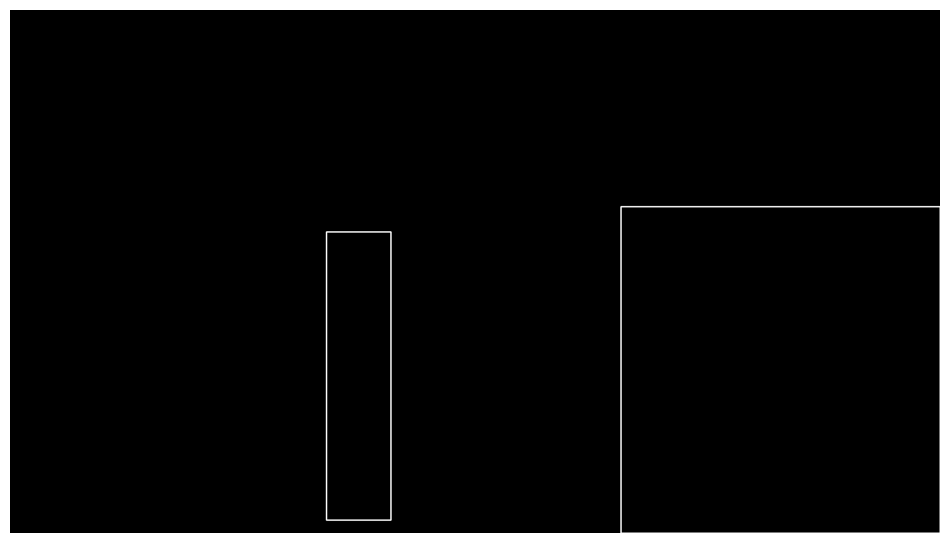

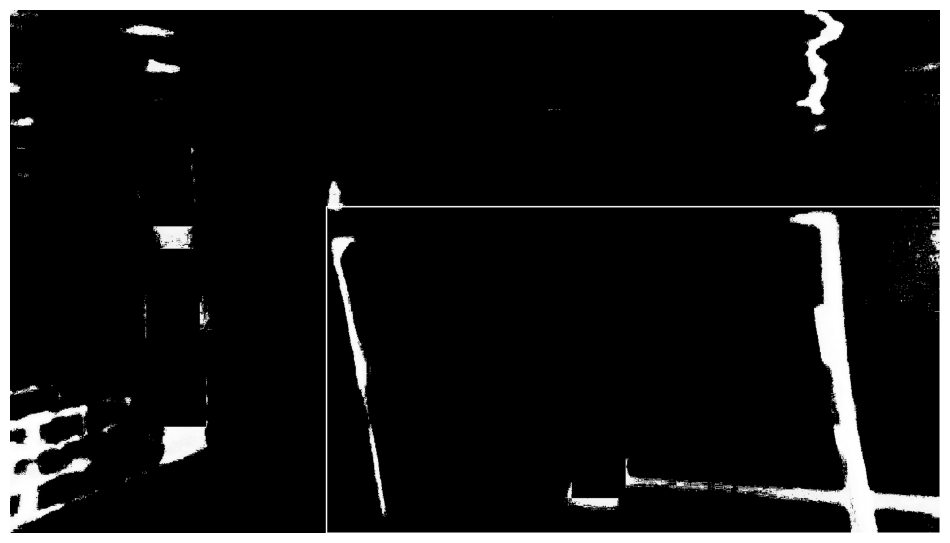

In [80]:
final_image = drawbox(image_path)